<a href="https://colab.research.google.com/github/pedro-de-bastos/CS166-Modeling-Simulation-and-Decision-Making/blob/main/Empirical_Analysis_of_Simulations_CS166_PCW_2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investigating Queue Length Based On Arrival Rate: Empirical Analysis of Simulations

In [1]:
import heapq
import numpy as np
import matplotlib.pyplot as plt

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')


In [2]:
# M/D/1 queue
import scipy.stats as sts


class Queue:
    def __init__(self, service_rate):
        # Store the deterministic service time for an M/D/1 queue
        self.service_time = 1 / service_rate
        # We start with an empty queue and the server not busy
        self.people_in_queue = 0
        self.people_being_served = 0

    def add_customer(self, schedule):
        # Add the customer to the queue
        self.people_in_queue += 1
        if self.people_being_served < 1:
            # This customer can be served immediately
            schedule.add_event_after(0, self.start_serving_customer)
            
    def start_serving_customer(self, schedule):
        # Move the customer from the queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1
        # Schedule when the server will be done with the customer
        schedule.add_event_after(
            self.service_time,
            self.finish_serving_customer)
            
    def finish_serving_customer(self, schedule):
        # Remove the customer from the server
        self.people_being_served -= 1
        if self.people_in_queue > 0:
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer)


class GroceryStore:
    
    def __init__(self, arrival_rate, service_rate):
        self.queue = Queue(service_rate)
        self.arrival_distribution = sts.expon(scale=1/arrival_rate)

    def add_customer(self, schedule):
        # Add this customer to the queue
        self.queue.add_customer(schedule)
        # Schedule when to add another customer
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)

    def run(self, schedule):
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)
        

def run_simulation(arrival_rate, service_rate, run_until):
    schedule = Schedule()
    grocery_store = GroceryStore(arrival_rate, service_rate)
    grocery_store.run(schedule)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    return grocery_store

# Helper Functions

In [42]:
def run_experiment(trials, arrival_rate, service_rate):
  result = ["" for i in range(trials)]

  for i in range(trials):
    grocery_store = run_simulation(arrival_rate=arrival_rate, service_rate=1, run_until=100)
    result[i] = grocery_store.queue.people_in_queue

  return result

In [44]:
def compute_stats(result):
  mean = np.mean(result)
  lower_bound = mean-1.96*(np.std(result)/len(result))
  upper_bound = mean+1.96*(np.std(result)/len(result))

  #print(f"Your mean is:{mean}, with a 95% confidence lower bound of {lower_bound} and upper bound of {upper_bound}")
  return {"mean":mean, "lower_bound":lower_bound, 'upper_bound':upper_bound}

# 100 Trials Experiment

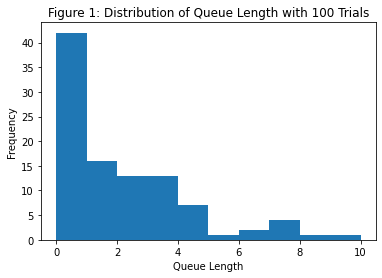

In [38]:
import matplotlib.pyplot as plt

result_100 = run_experiment(100, 0.8, 1)

plt.hist(result_100)
plt.title('Figure 1: Distribution of Queue Length with 100 Trials')
plt.xlabel('Queue Length')
plt.ylabel("Frequency")
plt.show()

In [35]:
stats_100 = compute_stats(result_100)
stats_100['upper_bound']-stats_100['lower_bound']

Your mean is:1.25, with a 95% confidence lower bound of 1.2129798595356527 and upper bound of 1.2870201404643473


0.07404028092869464

# 1000 Trials Experiment

Your mean is:1.655, with a 95% confidence lower bound of 1.65058674542316 and upper bound of 1.65941325457684


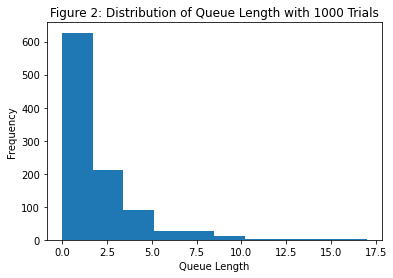

In [34]:
result_1000 = run_experiment(1000, 0.8, 1)

plt.hist(result_1000)
plt.title('Figure 2: Distribution of Queue Length with 1000 Trials')
plt.xlabel('Queue Length')
plt.ylabel("Frequency")
plt.show()

In [36]:
stats_1000 = compute_stats(result_1000)
stats_1000['upper_bound']-stats_1000['lower_bound']

Your mean is:1.655, with a 95% confidence lower bound of 1.65058674542316 and upper bound of 1.65941325457684


0.008826509153680107

# Distribution and Confidence Intervals Comparisson

## Distribution

First let us consider how the two figures above have changed. Figure 1 shows a 'fatter' tail: we have events of large queue lengths more frequently, whereas figure 2 shows that most events are around 0. Whereas both distributions resemble an exponential distribution, the exponential distribution of figure 2 (1000 trials) shows a sharper decrease in frequency from near 0 queue length to large queue lengths.

## Means and Confidence Intervals

Not surprisingly, considering the distributions, the mean queue length of the 100 trial experiment is smaller (approx. 1.9) than the mean of the 1000 trial experiment (approx. 1.66). Furthermore, we have that the 95% interval for the 100 trial experiment is much wider (0.07) than for the 1000 trial experiment (0.008). This is unsurprising because the sample size in the latter is much larger, which intuitively should give us more confidence about our mean estimate, and mathematically holds true because $\text{Standard Error} = \frac{s}{\sqrt{n}}$, where the standard error multiplied by the zscore tells us the intervals, $s$ is the standard deviation, and $n$ is the sample size. This means that the standard error is inversely proportional to the square root of the sample size (the larger the sample size, the smaller the standard error).

# When Does the Queue Length Exceed 5 People?

In [51]:
xs = np.linspace(0.8, 1, num = 30)
stats = ["" for i in range(len(xs))]

for i, j in enumerate(xs):
  results = run_experiment(100, j, 1)
  stats[i] = compute_stats(results)

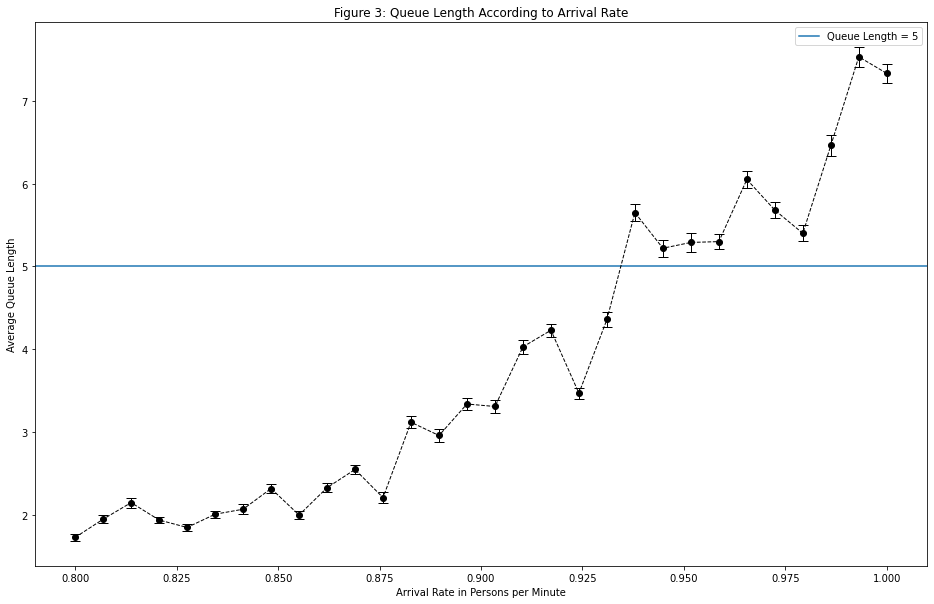

In [57]:
means = [i['mean'] for i in stats]
lbs = [i['lower_bound'] for i in stats]
errors = np.asarray(means)-np.asarray(lbs)

plt.figure(figsize=(16, 10))
plt.errorbar(xs, means, errors, color = 'black', marker='o', capsize=5, linestyle='--', linewidth=1)
plt.axhline(5, label="Queue Length = 5")
plt.title("Figure 3: Queue Length According to Arrival Rate")
plt.xlabel("Arrival Rate in Persons per Minute")
plt.ylabel("Average Queue Length")
plt.legend()
plt.show()

According to our graph, it seems that somewhere between arrival rates 0.925 and 0.95 our queue crossed the 5 person boundary. Notice, however, that there is some jagged volatility in our results, and that it is entirely possible that a slightly smaller arrival rate may produce a larger-than-5-person queue on random chance.

# Reflection

In this exercise, we looked at how we might use empirical statistics (the mean and confidence intervals of the mean) to analyze and predict patterns in our data. We showed that, according to our simulation, we expect queues with more than 5 people after an arrival rate of around 0.925 people per minute. We presented this data graphically, and discussed the effects of using more trials per experiment (i.e. for each different arrival rate, we ran the experiment multiple times to have a strong understanding of what the mean looks like).

The graphs above presented had all the standard requirements like labels and titles. In addition, I made them perception-friendly by minimizing the amount of extraneous information, using a lot of white space, and making sure that the elements like error bars were easy to discern.